In [ ]:
import numpy as np
import matplotlib.pyplot as plt # data visualization library

If possible, update your sklearn version to 1.5.2 to reduce variance in the versions.

In [ ]:
# The scikit-learn version is 1.5.2.

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [ ]:
# The numpy version should be 2.1.3.

In [ ]:
import sklearn
print('The numpy version is {}.'.format(np.__version__))

The numpy version is 2.1.3.


# PCA Faces

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [ ]:
# This is how you plot the first thirty pictures of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))

    ax.imshow(faces.data[i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [ ]:
D = faces.data
D.shape

Use the function `linalg.svd` from `scipy (version 1.14.1)` to compute the PCA for exercise 1a, b, c. The PCs can always point into two directions: the positive and the negative. To reproduce the result and to get the same image as provided as an option you need to use scipy. If you use numpy, you get however a similarly looking face from which you probably can infer the correct solution in ANS. Note: Using a different library may yield different results, trying to use direct PCA function from a library will not do the job here.  

In [ ]:
from scipy import linalg
# .. = linalg.svd(...)

# k-means initialization

In [ ]:
!pip3 show numpy

If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [ ]:
!pip3 install numpy --upgrade

The functions generating the datasets are given here:

In [ ]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization.

In [ ]:
def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    return X

In [ ]:
import scipy
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''
    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [ ]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [ ]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

In [ ]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [ ]:
dataID, D, labels, r = generateMoons(0.05,n)

In [ ]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = radius_neighbors_graph(D,0.5,include_self=False)
Y = spectral_clustering(W,r,init_centroids_greedy_pp)

plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()

# Your own personal Netflix
## Data Preprocessing

To read the dataset you might need to alter the path to look for it:

In [ ]:
import pandas as pd # pandas is a data manipulation library
# lets explore movies.csv
movies= pd.read_csv('ml-latest-small/movies.csv')
movies.head()

In [ ]:
# lets explore ratings.CSV
ratings=pd.read_csv('ml-latest-small/ratings.csv',sep=',')
ratings.head()

The given ratings are in the range of 0.5 and 5:

In [ ]:
min(ratings["rating"]), max(ratings["rating"])

We convert the sparse data representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [ ]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

We consider here only the movies which have been rated by more than 100 users. That are 134 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the principle and do not need a big dataset.

In [ ]:
np.sum(np.sum(df_movie_ratings!=0,0)>100)

In [ ]:
keep_movie = np.sum(df_movie_ratings!=0,0)>100
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

Furthermore, we will throw out all the users which have rated fewer than five movies. It would be hard anyways to make recommendations based on 4 movies.

In [ ]:
np.sum(np.sum(df_D!=0,1)>=5)

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [ ]:
keep_user = np.sum(df_D!=0,1)>=5
df_D = df_D.loc[keep_user,:]
df_D.head()

The movie number- title assignments are given as follows:

In [ ]:
movies.loc[movies['movieId'].isin(df_D.columns)]

The resulting data matrix is given as follows:

In [ ]:
D = df_D.to_numpy()
D.shape

## Optimization
Use the following initialization for your implementation of the optimization scheme.

In [ ]:
def matrix_completion(D,r, t_max=100, λ = 0.1):
    np.random.seed(0)
    X = np.random.normal(size =(d,r))
    Y = np.random.normal(size =(n,r))
    # Implement now the optimization procedure
    return X,Y

# MNIST ANN

In [1]:
import torch
import numpy as np
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cuda'

In [29]:
# hyper parameters to play with
dropout_1 = 0.1
dropout_2 = 0.1
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
batch_size = 128
epochs = 5

## Define the network architecture

In [30]:
import torch.nn as nn
import torch.nn.functional as F

HAS_PRINTED = False

# The embedding architecture returns the
# output of the penultimate layer
class ResBlock(nn.Module):
    def __init__(self, in_size:int, out_size:int, kernel_size:int, groups=1):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size, padding="same", groups=groups)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding="same", groups=groups)
        self.skip_connection = nn.Identity() if in_size==out_size else nn.Conv2d(in_size, out_size, kernel_size=1, padding="same")
        # normalization layers
        self.norm1 = nn.BatchNorm2d(in_size)
        self.norm2 = nn.BatchNorm2d(out_size)
        # activation functions
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()


    def forward(self, x: torch.Tensor)->torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        h = self.conv2(self.act2(self.norm2(h)))
        x = self.skip_connection(x)
        return x + h


class Embed(nn.Module):
    def __init__(self, embedding_dim:int, dropout1:float=dropout_1, dropout2:float=dropout_2):
        super(Embed, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=5, padding="same")
        # res blocks
        self.block1 = ResBlock(32, 32, 3, groups=2)
        self.block2 = ResBlock(32, 32, 3, groups=2)
        self.block3 = ResBlock(32, 64, 3, groups=4)
        self.block4 = ResBlock(64, 64, 3, groups=4)
        # pooling layer
        self.pool = nn.MaxPool2d(2)
        # normalization layers
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm1d(64)
        # linear layers
        self.fc1   = nn.Linear(64, 128)
        self.fc2   = nn.Linear(128, embedding_dim)
        # dropout
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)


    def forward(self, x:torch.Tensor)->torch.Tensor:
        global HAS_PRINTED
        out = F.relu(self.norm1(self.conv(x)))   # convolution to prepare for res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 1: {out.shape=}")
        out = self.block2(self.block1(out))  # first set of res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 2: {out.shape=}")
        out = self.norm2(self.pool(out))  # pooling
        if not HAS_PRINTED:
          print(f"tensor shape 3: {out.shape=}")
        out = self.block4(self.block3(out))  # second set of res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 4: {out.shape=}")
        out = torch.mean(out, dim=(-1, -2))  # average over spatial dimensions
        out = self.norm3(out)  # batch norm before fully connected part
        if not HAS_PRINTED:
          print(f"tensor shape 5: {out.shape=}")

        HAS_PRINTED = True

        # fully connected part:
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)

        return out

class Net(nn.Module):
    def __init__(self,embedding_dim, classifier):
        super(Net, self).__init__()
        self.embed = Embed(embedding_dim=embedding_dim)
        self.classifier = classifier

    def forward(self, x):
        out = self.embed(x)
        out = self.classifier(out)
        return out

    def conf(self,x):
        out = self.embed(x)
        return F.softmax(self.classifier(out),dim=1)

## Load the data: the first four MNIST classes

In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#classes = ('0', '1', '2', '3', '4', '5')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Select only some classes
idx = train_data.targets < c
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)


testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes
idx = testset.targets < c
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

==> Preparing data..


## Implementation of the training and testing

In [32]:
import time
def train_epoch(net, criterion, optimizer, trainloader, verbose=False):
    train_loss, correct, conf = 0, 0, 0
    start_time=time.time()
    net.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Set the gradient to zero
        optimizer.zero_grad()
        # Do the forward pass
        logits = net(inputs)
        loss = criterion(logits, targets)
        if verbose:
            print("loss:",loss.item())
        # Do the backward pass
        loss.backward()
        # Do a gradient descent step
        optimizer.step()

        with torch.no_grad(): #Disable gradient tracking and compute some statistics
            train_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    execution_time = (time.time() - start_time)
    n=len(trainloader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f'% (train_loss/len(trainloader), 100.*correct/n, correct, n, 100*conf/n, execution_time))
    return (100.*correct/n, 100*conf/n)

def test_acc(net, criterion, data_loader):
    net.eval()
    test_loss, correct, conf, total = 0,0,0,0
    with torch.no_grad(): # disable gradient tracking
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    n=len(data_loader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f'% (test_loss/max(len(data_loader),1), 100.*correct/n, correct, n, 100*conf/n))
    return (100.*correct/n, 100*conf/n)

## Create the model and perform the optimization for 10 epochs

In [33]:
d=2
# Model
print('==> Building model..')
classifier = nn.Linear(d, c, bias=True)
net = Net(embedding_dim=d, classifier=classifier)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

sgd = torch.optim.SGD([{'params': net.parameters()},],
                lr=lr, momentum=momentum, weight_decay=weight_decay)

==> Building model..


In [34]:
import os
for epoch in range(epochs):
    print('\nEpoch: %d' % epoch)
    train_epoch(net, criterion, sgd, trainloader)
    (acc,conf) = test_acc(net,criterion, testloader)

print('Saving..')
state = {'net': net.state_dict(),'acc': acc}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/net.t7')



Epoch: 0
tensor shape 1: out.shape=torch.Size([128, 32, 28, 28])
tensor shape 2: out.shape=torch.Size([128, 32, 28, 28])
tensor shape 3: out.shape=torch.Size([128, 32, 14, 14])
tensor shape 4: out.shape=torch.Size([128, 64, 14, 14])
tensor shape 5: out.shape=torch.Size([128, 64])
Loss: 0.764 | Acc: 74.818% (44891/60000) | Conf 65.98 | time (s): 18.14
Loss: 0.893 | Acc: 71.000% (7100/10000) | Conf 80.25

Epoch: 1
Loss: 0.268 | Acc: 93.868% (56321/60000) | Conf 88.57 | time (s): 16.37
Loss: 0.245 | Acc: 94.420% (9442/10000) | Conf 90.84

Epoch: 2
Loss: 0.189 | Acc: 95.693% (57416/60000) | Conf 92.22 | time (s): 16.32
Loss: 0.196 | Acc: 95.080% (9508/10000) | Conf 93.45

Epoch: 3
Loss: 0.161 | Acc: 96.422% (57853/60000) | Conf 93.84 | time (s): 16.17
Loss: 0.159 | Acc: 96.140% (9614/10000) | Conf 93.37

Epoch: 4
Loss: 0.132 | Acc: 96.942% (58165/60000) | Conf 94.91 | time (s): 16.07
Loss: 0.137 | Acc: 96.900% (9690/10000) | Conf 95.34
Saving..


## Plot the latent space representations

In [35]:
# Load the saved net
classifier = nn.Linear(d, c,bias=True)
net = Net(embedding_dim=d, classifier=classifier)
checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()
print('ACC:\t',checkpoint['acc'])

ACC:	 96.9


<ipython-input-35-82b45aa90221>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')


In [36]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def scatter_pictures(inputs, outputs, samples=30):
    zoom = 0.7

    for j in range(min(inputs.shape[0],samples)):
        image = inputs[j,:,:,:].squeeze()
        im = OffsetImage(image, cmap="gray",zoom=zoom)
        ab = AnnotationBbox(im, (outputs[j,0], outputs[j,1]), xycoords='data', frameon=False, alpha=0.5)
        ax.add_artist(ab)

In [37]:
import matplotlib.pyplot as plt
def plot_conf(conf, show_class_assignment=False, x_max=20, y_max=20, x_min=-1, y_min=-1):
    x = np.arange(x_min, x_max, 0.05)
    y = np.arange(y_min, y_max, 0.05)

    xx, yy = np.meshgrid(x, y)
    X = np.array([xx,yy]).reshape(2,x.shape[0]*y.shape[0]).T
    Z = conf(torch.from_numpy(X).float()).t()
    Z = Z.reshape(-1,y.shape[0],x.shape[0]).cpu().detach().numpy()
    if show_class_assignment:
        h = plt.contourf(x,y,Z.argmax(axis=0),cmap='magma')
    else:
        h = plt.contourf(x,y,Z.max(axis=0),cmap='magma')
        plt.clim(0, 1)
        cb = plt.colorbar()
        cb.set_label('Confidence')
    plt.axis('scaled')

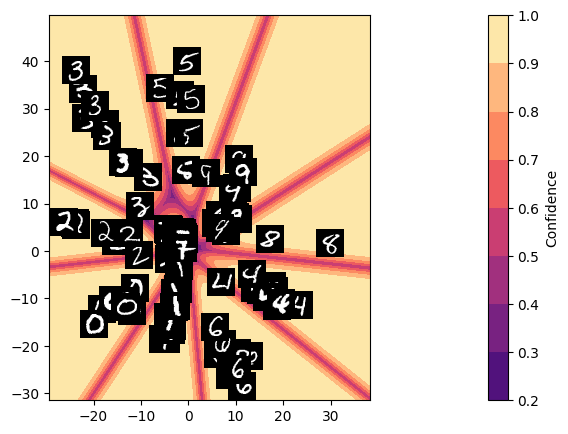

In [38]:
inputs, targets = next(iter(testloader)) #load a batch
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)

## Plot Representations of out-of-distribution data

In [13]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans)
trainloader_fashion = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=trans)
testloader_fashion = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

==> Preparing data..


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.93MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



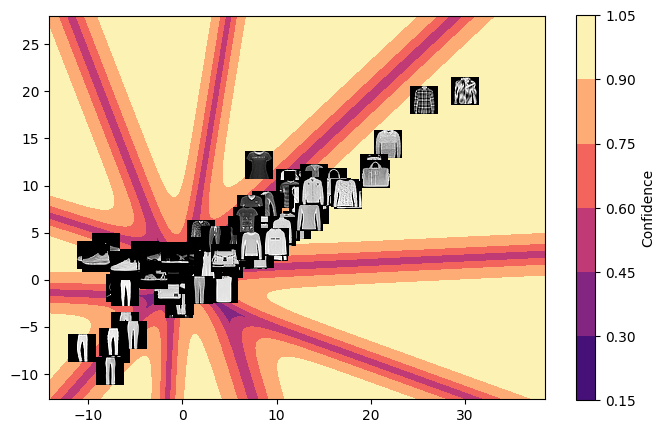

In [14]:
inputs, targets = next(iter(testloader_fashion))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)